<img src="resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Workshop SWDB 2024 </h1> 
<h3 align="center">Day 3 2024 - Neuron Morphology</h3> 
<h3 align="center">Notebook 3: EM Synaptic Density</h3> 

In [1]:
%load_ext autoreload

In [2]:
#all imports
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import cloudvolume
from cloudfiles import CloudFiles
from meshparty import skeleton
import skeleton_plot as skelplot

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   
<p>The Electron Microscopy (EM) data includes information about the synaptic connectivity between neurons. In this notebook we will: 
    
<ul>
<li> extract information about synapse number and synapse size
<li> calculate the synapse density as a function of distance from soma
<li> explore the variation of synapse-density profiles across cell types and brain areas
</ul>
    
</div>

In [3]:
%autoreload
from utils.skeleton_loading_utils import load_em_skeleton_as_meshwork

In [4]:
skeleton_id = 864691135591041291
sk, conversion_factor = load_em_skeleton_as_meshwork(skeleton_id)

The meshwork skeleton is very handy for masking and performing graph operations, but does not capture some of the other features attached to the skeleton nodes. For this, we will also use vertex properties from the precomputed skeleton

In [5]:
input_directory = "precomputed://gs://allen_neuroglancer_ccf/em_minnie65_v661"
cv_obj = cloudvolume.CloudVolume(input_directory, use_https = True) # Initialize cloud volume
cv_sk = cv_obj.skeleton.get(skeleton_id)

skel_df = pd.DataFrame({'vertex_xyz': [x for x in cv_sk.vertices],
                        'vertex_x': [x[0] for x in cv_sk.vertices],
                        'vertex_y': [x[1] for x in cv_sk.vertices],
                        'vertex_z': [x[2] for x in cv_sk.vertices],
                        'd_path_um': sk.distance_to_root / conversion_factor,
                        'compartment': cv_sk.compartment, 
                        'presyn_counts': cv_sk.presyn_counts, 
                        'presyn_size': cv_sk.presyn_size, 
                        'postsyn_counts': cv_sk.postsyn_counts, 
                        'postsyn_size': cv_sk.postsyn_size,})
skel_df.index.names = ['vertex_index']

skel_df.head(3)

,vertex_xyz,vertex_x,vertex_y,vertex_z,d_path_um,compartment,presyn_counts,presyn_size,postsyn_counts,postsyn_size
vertex_index,,,,,,,,,,
0,"[8028168.5, 1049868.0, 8225758.0]",8028168.5,1049868.000,8225758.0,775.749807,2.0,0.0,0.0,0.0,0.0
1,"[8033898.5, 1053996.1, 8224633.0]",8033898.5,1053996.125,8224633.0,768.555345,2.0,0.0,0.0,0.0,0.0
2,"[8031754.0, 1052311.5, 8224850.0]",8031754.0,1052311.500,8224850.0,771.316866,2.0,0.0,0.0,0.0,0.0


Tip: you may use the utility function `load_em_skeleton_as_df(skeleton_id)` for convenience

In [6]:
from utils.skeleton_loading_utils import load_em_skeleton_as_df

skel_df = load_em_skeleton_as_df(skeleton_id)

### Get euclidean distance to soma, for each vertex

In [7]:
# get the position of the soma
soma_loc = skel_df.loc[skel_df.compartment==1]['vertex_xyz'].values[0]

# calculate euclidean distance at each vertex
skel_df['d_euc_um'] = skel_df.vertex_xyz.apply(lambda x: np.linalg.norm(x - soma_loc) / conversion_factor)

skel_df.tail(3)

,vertex_xyz,vertex_x,vertex_y,vertex_z,d_path_um,compartment,presyn_counts,presyn_size,postsyn_counts,postsyn_size,d_euc_um
vertex_index,,,,,,,,,,,
9151,"[7739545.0, 1135027.2, 9053995.0]",7739545.0,1135027.250,9053995.0,1766.321002,2.0,1.0,7576.0,0.0,0.0,669.498625
9152,"[7739452.5, 1136071.9, 9053438.0]",7739452.5,1136071.875,9053438.0,1767.508456,2.0,0.0,0.0,0.0,0.0,669.565125
9153,"[8091754.0, 858805.0, 8556121.0]",8091754.0,858805.000,8556121.0,0.000000,1.0,0.0,0.0,134.0,542540.0,0.000000


### Visualize euclidean distance and path distance as a histogram

Text(0.5, 1.0, 'Output synapses')

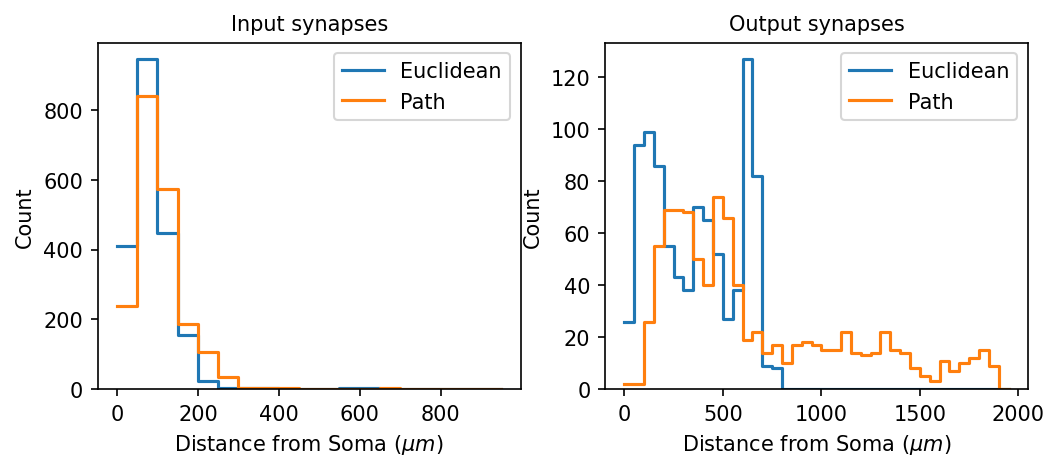

In [8]:
# For bins, use 50 micron bins up to a distance of 1000 microns.
out_syn_skel_df = skel_df.query("presyn_counts>0")
in_syn_skel_df = skel_df.query("postsyn_counts>0")

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)

bins = np.arange(0, 1000, 50)
sns.histplot(
    x='d_euc_um',
    data=in_syn_skel_df,
    bins=bins,
    ax=ax[0],
    stat='count',
    element='step',
    fill=False,
)

sns.histplot(
    x='d_path_um',
    data=in_syn_skel_df,
    bins=bins,
    ax=ax[0],
    stat='count',
    element='step',
    fill=False,
)
ax[0].legend(['Euclidean', 'Path'])
ax[0].set_xlabel('Distance from Soma ($\mu m$)')
ax[0].set_title('Input synapses', fontsize=10)


bins = np.arange(0, 2000, 50)
sns.histplot(
    x='d_euc_um',
    data=out_syn_skel_df,
    bins=bins,
    ax=ax[1],
    stat='count',
    element='step',
    fill=False,
)

sns.histplot(
    x='d_path_um',
    data=out_syn_skel_df,
    bins=bins,
    ax=ax[1],
    stat='count',
    element='step',
    fill=False,
)
ax[1].legend(['Euclidean', 'Path'])
ax[1].set_xlabel('Distance from Soma ($\mu m$)')
ax[1].set_title('Output synapses', fontsize=10)

What does the difference between euclidean distance and path distance tell you?

## Visualize cell with synapses

(7726840.5, 8438740.0, 1497648.0, 675351.375)

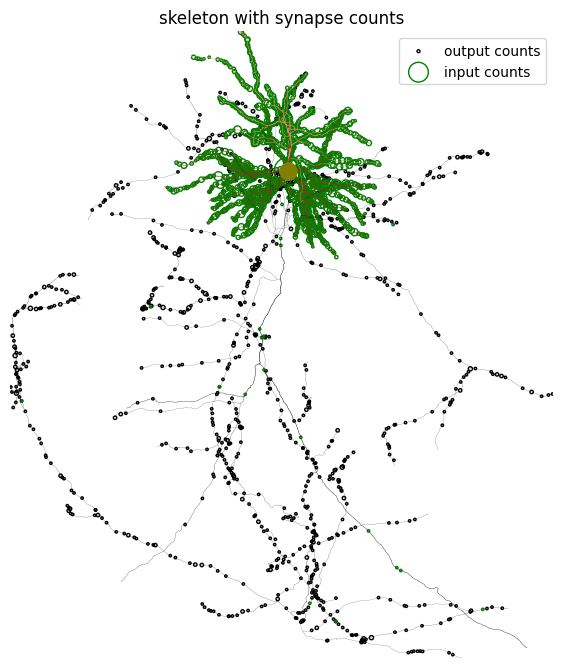

In [9]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    title="skeleton with synapse counts",
    line_width=1,
    plot_soma=True,
    soma_size = 150,
    pull_radius=True,
    invert_y=True,
    pull_compartment_colors=True,
    x="x",
    y="y",
    skel_color_map = { 3: "firebrick",4: "salmon",2: "black",1: "olive" },
)

# Plot output synapses
ax.scatter(x=skel_df.vertex_x, y=skel_df.vertex_y,
           s=3*skel_df.presyn_counts, 
           edgecolors ='k', 
           facecolors='none',
           label='output counts')

# # Plot input synapses
ax.scatter(x=skel_df.vertex_x, y=skel_df.vertex_y, 
           s=3*skel_df.postsyn_counts, 
           edgecolors ='g', 
           facecolors='none',
           label='input counts')

ax.legend()

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')

### Calculate synaptic density along each segment

In [10]:
df_list = []
for ss in range(len(sk.segments)):
    local_segment = sk.segments[ss]
    
    # estimate the path length of the segment
    local_length = sk.path_length(sk.path_between(local_segment[0], local_segment[-1])) / conversion_factor

    # get the number of synapses along the segment
    local_presyn_sum = skel_df.iloc[local_segment].presyn_counts.sum()
    local_postsyn_sum = skel_df.iloc[local_segment].postsyn_counts.sum()

    # calculate segment synapse density
    local_density_presyn = local_presyn_sum / local_length # syn_per_um
    local_density_postsyn = local_postsyn_sum / local_length # syn_per_um
    
    df_list.append(pd.DataFrame({'vertex_index': local_segment, 
                                 'output_density_segment': local_density_presyn*np.ones(len(local_segment)),
                                 'input_density_segment': local_density_postsyn}))

# Concatenate to get the segment-synapse-density for every vertex
synapse_density_df = pd.concat(df_list).set_index('vertex_index')

# Merge column into the skeleton dataframe
skel_df = pd.merge(skel_df, synapse_density_df, left_index=True, right_index=True)

### Plot synapse density as a function of path-distance from soma

Text(0.5, 1.0, 'Output synapse-density on segment')

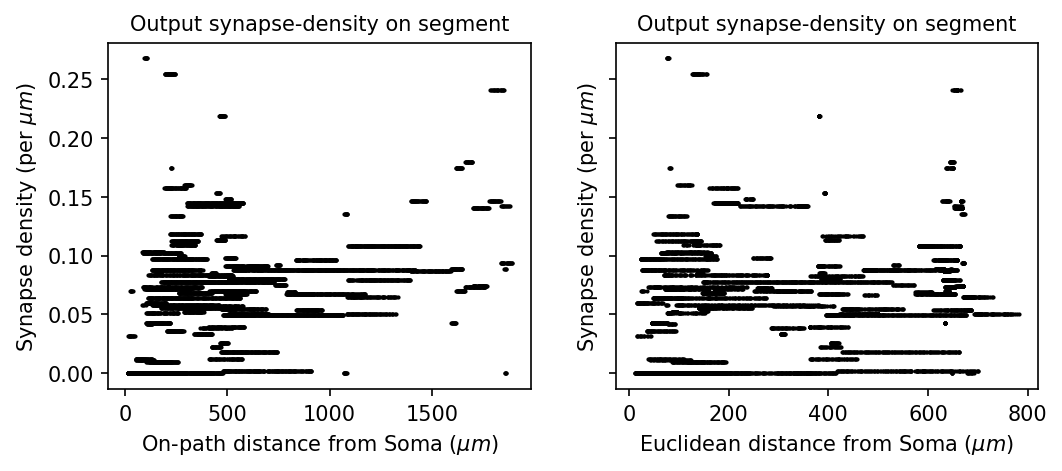

In [11]:
fig, ax = plt.subplots(1,2,figsize=(8,3), dpi=150, sharey=True)

ax[0].scatter(x=skel_df.d_path_um, y=skel_df.output_density_segment, s=1, c='k')
ax[0].set_xlabel('On-path distance from Soma ($\mu m$)')
ax[0].set_ylabel('Synapse density (per $\mu m$)')
ax[0].set_title('Output synapse-density on segment', fontsize=10)

ax[1].scatter(x=skel_df.d_euc_um, y=skel_df.output_density_segment, s=1, c='k')
ax[1].set_xlabel('Euclidean distance from Soma ($\mu m$)')
ax[1].set_ylabel('Synapse density (per $\mu m$)')
ax[1].set_title('Output synapse-density on segment', fontsize=10)

## Next: move from example neuron into population, with segment properties

In [22]:
%autoreload
from utils.skeleton_loading_utils import load_em_segmentprops_to_df


In [23]:
# Load the skeleton segment properties
all_skeletons_df = load_em_segmentprops_to_df()

# Add 'synapse density' as function of total path length
all_skeletons_df['input_density'] = all_skeletons_df.input_synapse_count/all_skeletons_df.dendrite_length_um
all_skeletons_df['output_density'] = all_skeletons_df.output_synapse_count/all_skeletons_df.axon_length_um

all_skeletons_df.head()

,nucleus_id,axon_length_um,dendrite_length_um,input_synapse_count,output_synapse_count,cell_type,brain_area,input_density,output_density
864691136452054015,nuc:292669,29135.583984,5727.043945,13541.0,5184.0,BC,V1,2.364396,0.177927
864691136309871706,nuc:516758,10573.615234,5390.727051,6278.0,930.0,23P,RL,1.164592,0.087955
864691134940133219,nuc:230650,7056.800781,2944.693115,3442.0,1517.0,5P-IT,V1,1.168882,0.214970
864691135954311176,nuc:256622,19841.064453,4158.631348,8999.0,3858.0,BC,V1,2.163933,0.194445
864691136371168136,nuc:260609,16452.632812,3435.493896,6809.0,3906.0,BC,V1,1.981957,0.237409


In [100]:
cell_type_colormap = {'MC': [0,0,1],
                      'BC': [0,.2,1],
                      'BPC': [0,.35,1],
                      'NGC': [0,1,1],
                      '23P': [1,0,0],
                      '4P': [1,.2,0],
                      '5P-IT': [1,.3,0],
                      '5P-ET': [1,.5,0],
                      '5P-NP': [1,.7,0],
                      '6P-IT': [1, .8, 0],
                      '6P-CT': [1,.8,.2],
                      'none': [0.5,0.5,0.5],}

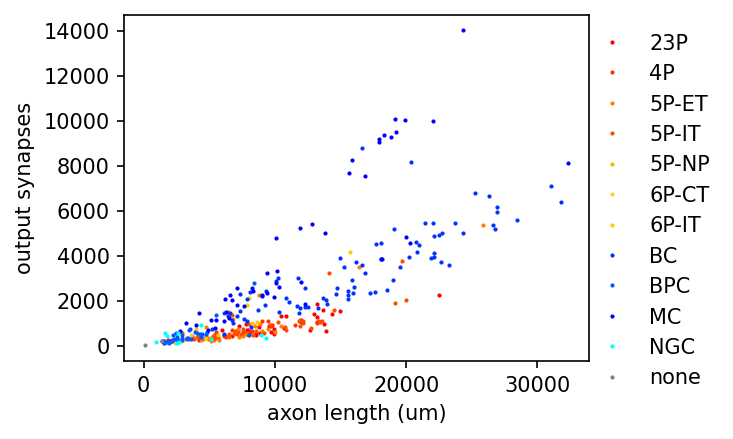

In [101]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150, sharey=True)

groups = all_skeletons_df.groupby('cell_type')
for name, group in groups:
    ax.plot(group.axon_length_um, group.output_synapse_count, 
            marker='o', linestyle='', ms=1, 
            label=name, color=cell_type_colormap[name] )
    
ax.set_xlabel('axon length (um)')
ax.set_ylabel('output synapses')
ax.legend(loc='upper right', bbox_to_anchor=(1.3,1,0,0), frameon=False)

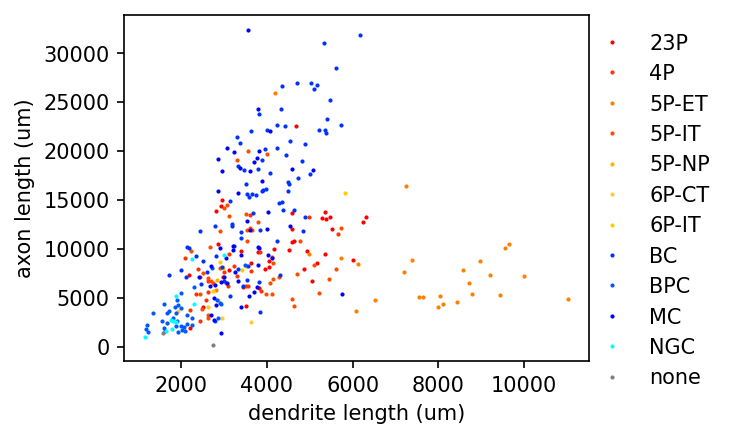

In [102]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150, sharey=True)

groups = all_skeletons_df.groupby('cell_type')
for name, group in groups:
    ax.plot(group.dendrite_length_um, group.axon_length_um, 
            marker='o', linestyle='', ms=1, 
            label=name, color=cell_type_colormap[name] )
    
ax.set_ylabel('axon length (um)')
ax.set_xlabel('dendrite length (um)')
ax.legend(loc='upper right', bbox_to_anchor=(1.3,1,0,0), frameon=False)

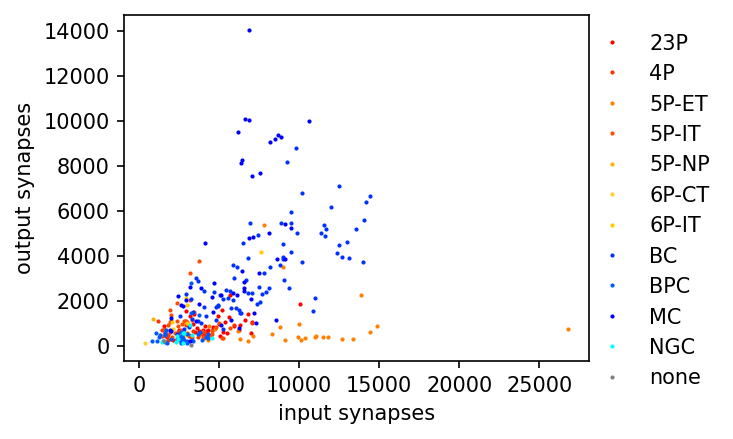

In [103]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150, sharey=True)

groups = all_skeletons_df.groupby('cell_type')
for name, group in groups:
    ax.plot(group.input_synapse_count, group.output_synapse_count, 
            marker='o', linestyle='', ms=1, 
            label=name, color=cell_type_colormap[name] )
    
ax.set_xlabel('input synapses')
ax.set_ylabel('output synapses')
ax.legend(loc='upper right', bbox_to_anchor=(1.3,1,0,0), frameon=False)

In [ ]:
## compare synapse density curves for 1) cell types, 2) brain areas